In [1]:
import argparse
import os
import sys
import random
sys.path.append(".")
import numpy as np
import time
import torch as th
import intel_extension_for_pytorch as ipex
from guided_diffusion.bratsloader import BRATSDataset3D_midslice
import torchvision.utils as vutils
from guided_diffusion.utils import staple
from guided_diffusion.script_util import (
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    add_dict_to_argparser,
    args_to_dict,
)
import torchvision.transforms as transforms

In [2]:
seed=10
th.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [ ]:
def create_argparser():
    defaults = dict(
        data_name = 'BRATS',
        data_dir="../dataset/brats2020/testing",
        clip_denoised=True,
        num_samples=1,
        batch_size=1,
        use_ddim=False,
        model_path="",         #path to pretrain model
        num_ensemble=5,      #number of samples in the ensemble
        gpu_dev = "0",
        out_dir='./results/',
        multi_gpu = None,
        debug = False
    )
    defaults.update(model_and_diffusion_defaults())
    parser = argparse.ArgumentParser()
    add_dict_to_argparser(parser, defaults)
    return parser

In [ ]:
args = create_argparser().parse_args()

/home/u101753/.conda/envs/MedSegDiff/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


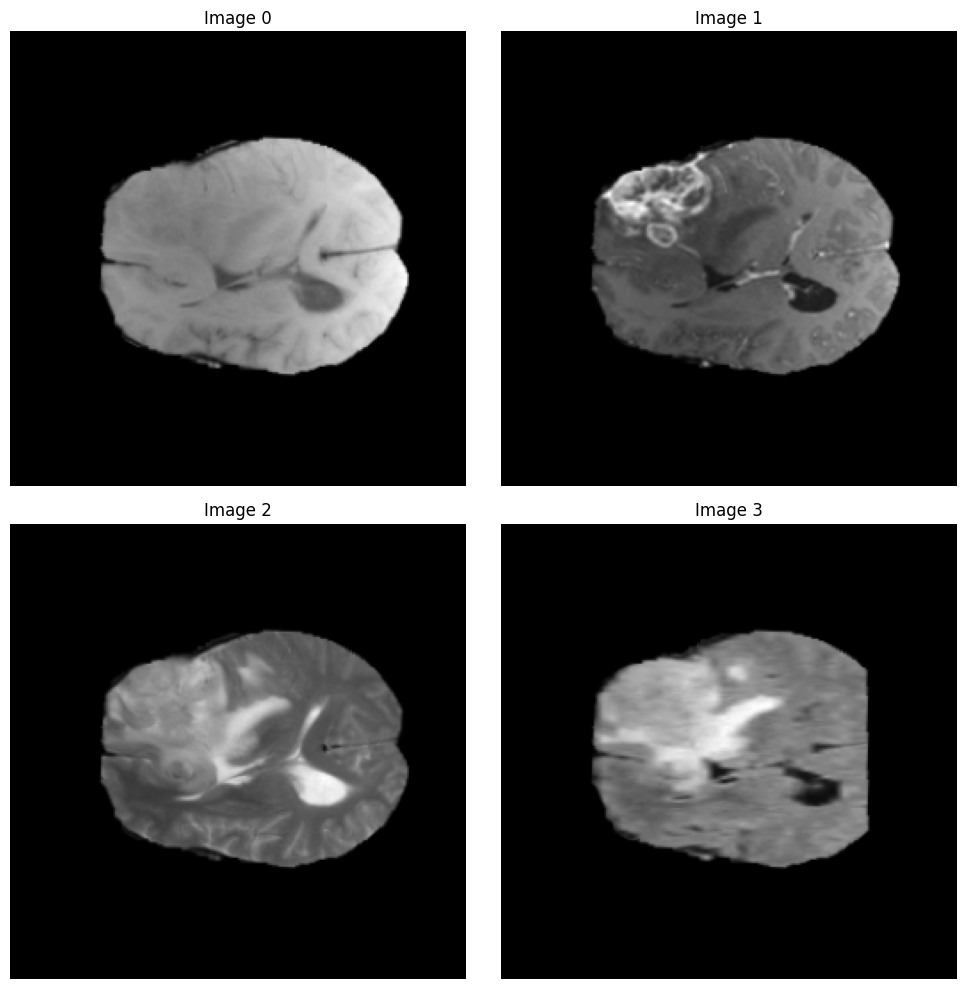

In [3]:
tran_list = [transforms.Resize((256,256)),]
transform_test = transforms.Compose(tran_list)

ds = BRATSDataset3D_midslice('data/MICCAI_BraTS2020_TrainingData',transform_test)

datal = th.utils.data.DataLoader(
    ds,
    batch_size=1,
    shuffle=True)
data = iter(datal)

# print(args.batch_size)

# model, diffusion = create_model_and_diffusion(
#     **args_to_dict(args, model_and_diffusion_defaults().keys())
# )

######################
# state_dict = dist_util.load_state_dict(args.model_path, map_location="cpu")
# from collections import OrderedDict
# new_state_dict = OrderedDict()
# for k, v in state_dict.items():
#     # name = k[7:] # remove `module.`
#     if 'module.' in k:
#         new_state_dict[k[7:]] = v
#         # load params
#     else:
#         new_state_dict = state_dict

# model.load_state_dict(new_state_dict)
######################

# model.eval()
# model = ipex.optimize(model, dtype=th.bfloat16)

for _ in range(len(data)):
    b, m, path = next(data)  #should return an image from the dataloader "data"
    c = th.randn_like(b[:, :1, ...])
    img = th.cat((b, c), dim=1)     #add a noise channel$

    slice_ID=path[0].split("_")[-2]

    # enslist = []

    # for i in range(args.num_ensemble):  #this is for the generation of an ensemble of 5 masks.
    #     model_kwargs = {}
    #     start_time = time.time()

    #     print("sample " + str(i))
    #     sample_fn = (
    #         diffusion.p_sample_loop_known if not args.use_ddim else diffusion.ddim_sample_loop_known
    #     )

    #     with th.no_grad(), th.cpu.amp.autocast():
    #         sample, x_noisy, org, cal, cal_out = sample_fn(
    #             model,
    #             (args.batch_size, args.in_ch, args.image_size, args.image_size), img,
    #             step = args.diffusion_steps,
    #             clip_denoised=args.clip_denoised,
    #             model_kwargs=model_kwargs,
    #         )

    #     print("--- %s seconds ---" % (time.time() - start_time))

    #     co = th.tensor(cal_out)
    #     if args.version == 'new':
    #         enslist.append(sample[:,-1,:,:])
    #     else:
    #         enslist.append(co)

    # ensres = staple(th.stack(enslist,dim=0)).squeeze(0)
    # vutils.save_image(ensres, fp = os.path.join(args.out_dir, str(slice_ID)+'_output_ens'+".jpg"), nrow = 1, padding = 10)

    # Extract the four images
    import matplotlib.pyplot as plt
    image_0 = b[0, 0].squeeze().cpu().numpy()
    image_1 = b[0, 1].squeeze().cpu().numpy()
    image_2 = b[0, 2].squeeze().cpu().numpy()
    image_3 = b[0, 3].squeeze().cpu().numpy()

    # Create a 2x2 grid of subplots
    plt.figure(figsize=(10, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(image_0, cmap='gray')
    plt.title("Image 0")
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(image_1, cmap='gray')
    plt.title("Image 1")
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(image_2, cmap='gray')
    plt.title("Image 2")
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(image_3, cmap='gray')
    plt.title("Image 3")
    plt.axis('off')

    plt.tight_layout()  # Ensure proper spacing between subplots
    plt.show()
    
    break

In [46]:
from PIL import Image
im = Image.fromarray(image_0)
im = im.convert('RGB')
im.save("your_file.jpg")

In [57]:
import matplotlib.image
matplotlib.image.imsave('your_file.jpg', m.squeeze().cpu().numpy())

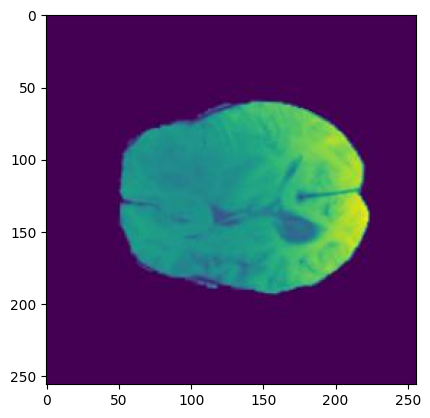

In [56]:
import matplotlib.image as mpimg
img=mpimg.imread('your_file.jpg')
plt.imshow(img, cmap='gray')

In [6]:
import nibabel as nib
import matplotlib.pyplot as plt

test_load = nib.load('data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t2.nii.gz').get_fdata()
test_seg = nib.load('data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_seg.nii.gz').get_fdata()

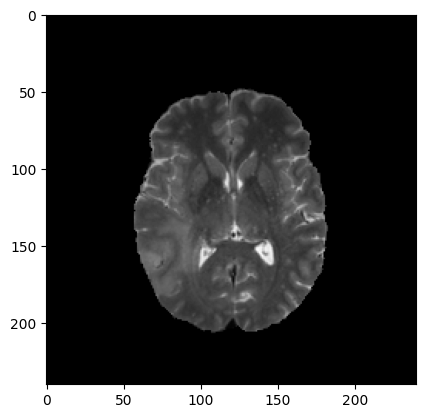

In [7]:
from scipy import ndimage
rotated_img = ndimage.rotate(test_load[:,:,int(155/2)], -90)
rotated_seg = ndimage.rotate(test_seg[:,:,int(155/2)], -90)
plt.imshow(rotated_img, cmap='gray')
plt.show()

In [8]:
rotated_seg[rotated_seg>rotated_seg.mean()] = 1

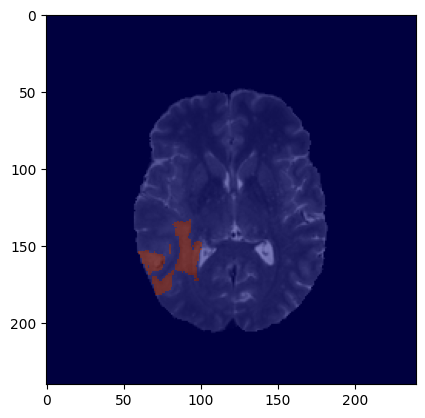

In [9]:
rotated_seg[rotated_seg>rotated_seg.mean()] = 1
plt.imshow(rotated_img, cmap='gray')
plt.imshow(rotated_seg, cmap='jet', interpolation='none',alpha=0.5)
plt.show()

In [10]:
rotated_img.shape

(240, 240)

In [31]:
from segmentation_mask_overlay import overlay_masks
fig = overlay_masks(rotated_img, rotated_seg, colors = 'r', beta = .8, return_type="numpy")

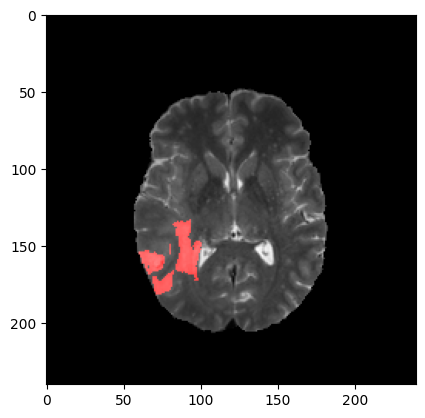

In [32]:
plt.imshow(fig)

In [66]:
path = 'data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001'
for root, dirs, files in os.walk(path):
    files.sort()
    print(files)
    # datapoint = dict()
    # # extract all files as channels
    # for f in files:
    #     seqtype = f.split('_')[3].split('.')[0]
    #     datapoint[seqtype] = os.path.join(root, f)

['BraTS20_Training_001_flair.nii.gz', 'BraTS20_Training_001_seg.nii.gz', 'BraTS20_Training_001_t1.nii.gz', 'BraTS20_Training_001_t1ce.nii.gz', 'BraTS20_Training_001_t2.nii.gz']


In [92]:
dir_list = os.listdir(path)
dir_list.sort()
datapoint = dict()
for f in dir_list:
    seqtype = f.split('_')[3].split('.')[0]
    datapoint[seqtype] = os.path.join(root, f)

assert set(datapoint.keys()) == set(['t1', 't1ce', 't2', 'flair', 'seg'])
                                 

{'flair', 'seg', 't1', 't1ce', 't2'}

In [133]:
import torch
import intel_extension_for_pytorch as ipex
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from guided_diffusion.bratsloader import BRATSDataset3D

batch_size = 8
in_ch = 4
img_size = 256

tran_list = [transforms.Resize((img_size,img_size))]
transform_test = transforms.Compose(tran_list)

training_data = BRATSDataset3D('data/MICCAI_BraTS2020_TrainingData/',transform_test)


training_dataset = DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True)

validation_data = BRATSDataset3D('data/MICCAI_BraTS2020_TrainingData/',transform_test)

validation_dataset = DataLoader(
    validation_data,
    batch_size=batch_size,
    shuffle=True)

# Set device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
from guided_diffusion.unet_parts import BasicUNet
model = BasicUNet(n_channels=in_ch, n_classes=1).to(device)
# print(model)


loss_fn = nn.BCEWithLogitsLoss
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    model, optimizer = ipex.optimize(model, optimizer=optimizer, dtype=torch.bfloat16)
    
    for batch, (X, y, _) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        with torch.cpu.amp.autocast():
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if batch % 1 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Using cpu device


In [111]:
loss_fn = nn.BCEWithLogitsLoss
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 